# Import Libraries

In [1]:
from astropy.io import fits as pyfits # To read FITS files

import os # To use Linux OS commands

import sys # For system commands

import matplotlib.pyplot as plt # For graphing capabilities
import matplotlib.cm as cm # For colourmap

from scipy.interpolate import griddata # For grid interpolation

import numpy as np # To handle data with numpy arrays

import astropy
#astropy.__citation__

# Import Data

In [2]:
hdulist = pyfits.open('Raster_Scan.fits')
hdu0 = hdulist[0]
date = hdu0.header['DATE']
hdu1 = hdulist[1]

In [3]:
scans={}
for i in range(2,92):
        scans["scan{}".format(i-2)] = hdulist[i]

## Extract Important Variables From Data

In [4]:
count_Per_Kelvin1 = scans['scan0'].header['HZPERK1']
count_Per_Kelvin2 = scans['scan0'].header['HZPERK2']
nom_sys_temp = hdu1.header['NOMTSYS']

# Extract Raster Scan Data

In [5]:
def raster(scans, polarisation, direction):
    
    count_LCP = []
    count_RCP = []
    RA = []
    Dec = []
    counter = 0
    
    # Calibration Data
    if (direction == 'C'):
        title_part_2 = 'Calibration Raster Scan Data'
        i = 0
        count_LCP = np.append(count_LCP , scans['scan{}'.format(i)].data['Count1']) # Left-Circular-Polarisation Count
        count_RCP = np.append(count_RCP , scans['scan{}'.format(i)].data['Count2']) # Right-Circular-Polarisation Count
        RA = np.append(RA, scans['scan{}'.format(i)].data['RA_J2000']) # Julian Epoch, Right Ascension
        Dec = np.append(Dec, scans['scan{}'.format(i)].data['Dec_J2000']) # Julian Epoch, Declination
    
    # Horizontal Data
    if (direction == 'H'):
        title_part_2 = 'Horizontal Raster Scan Data'
        for i in range(1,46):
            counter = counter + 1
            count_LCP = np.append(count_LCP , scans['scan{}'.format(i)].data['Count1']) # Left-Circular-Polarisation Count
            count_RCP = np.append(count_RCP , scans['scan{}'.format(i)].data['Count2']) # Right-Circular-Polarisation Count
            RA = np.append(RA, scans['scan{}'.format(i)].data['RA_J2000']) # Julian Epoch, Right Ascension
            Dec = np.append(Dec, scans['scan{}'.format(i)].data['Dec_J2000']) # Julian Epoch, Declination
    # Vertical Data
    if (direction == 'V'):
        title_part_2 = 'Vertical Raster Scan Data'
        for i in range(46,90):
            counter = counter + 1
            count_LCP = np.append(count_LCP , scans['scan{}'.format(i)].data['Count1']) # Left-Circular-Polarisation Count
            count_RCP = np.append(count_RCP , scans['scan{}'.format(i)].data['Count2']) # Right-Circular-Polarisation Count
            RA = np.append(RA, scans['scan{}'.format(i)].data['RA_J2000']) # Julian Epoch, Right Ascension
            Dec = np.append(Dec, scans['scan{}'.format(i)].data['Dec_J2000']) # Julian Epoch, Declination
    
    temp_LCP = (count_LCP / count_Per_Kelvin1) - nom_sys_temp
    temp_RCP = (count_RCP / count_Per_Kelvin2) - nom_sys_temp
    
    # Create Figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
    ax.set_facecolor('black')
    plt.xlabel('Right Ascension (J2000 Epoch)', fontsize = 16)
    plt.ylabel('Declination (J2000 Epoch)', fontsize = 16)
    
    if polarisation == 'LCP':
        values = temp_LCP
        title_part_1 = 'LCP'
    if polarisation == 'RCP':
        values = temp_RCP
        title_part_1 = 'RCP'
    
    #title = date + ' ' + title_part_1 + ' ' + title_part_2 + ' (Measured at 12.18 GHz)'
    #plt.title(title, fontsize = 16)
    
    plt.scatter(RA, Dec, c = values, cmap = cm.hot, s = 1)
    cbar = plt.colorbar(pad = 0.02, fraction = 0.05)
    cbar.set_label('Temperature', rotation=270, labelpad=-55, size = 15)
    cbar.ax.tick_params(labelsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.axis('equal')
    plt.show()
    print(counter)
    
    return RA, Dec, values

## LCP Horizontal

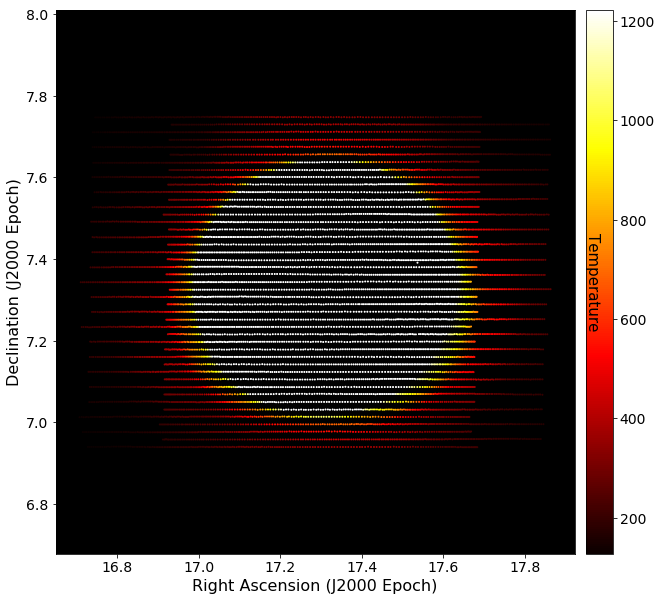

45


In [6]:
RA_LCP_H, Dec_LCP_H, values_LCP_H = raster(scans, 'LCP', 'H')

## LCP Vertical

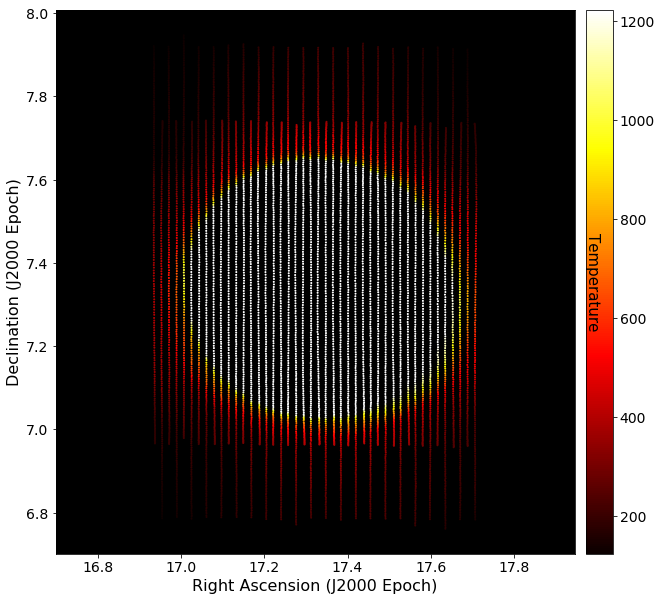

44


In [7]:
RA_LCP_V, Dec_LCP_V, values_LCP_V = raster(scans, 'LCP', 'V')

## RCP Horizontal

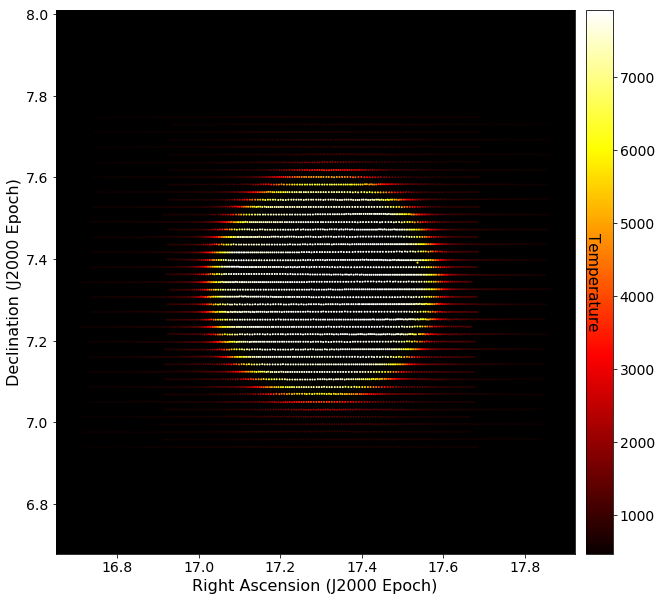

45


In [8]:
RA_RCP_H, Dec_RCP_H, values_RCP_H = raster(scans, 'RCP', 'H')

## RCP Vertical

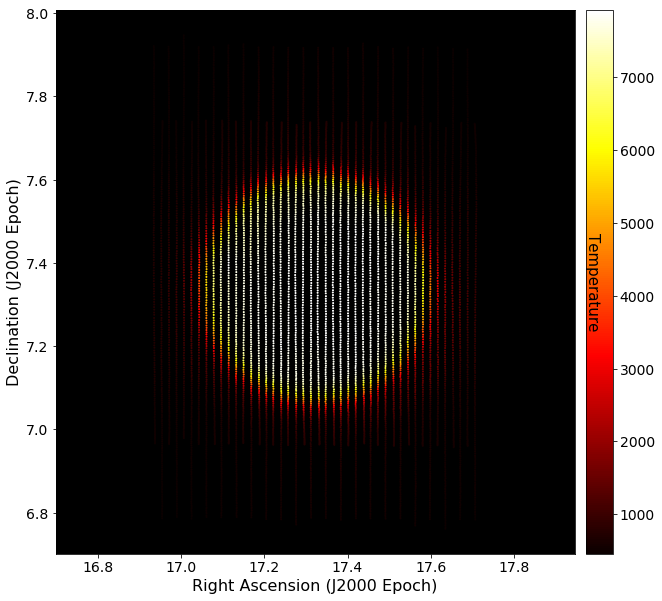

44


In [9]:
RA_RCP_V, Dec_RCP_V, values_RCP_V = raster(scans, 'RCP', 'V')

# Interpolate Data

In [10]:
# Create Grid
grid_x, grid_y = np.mgrid[16.85:17.85:1500j, 6.95:7.75:1500j]

In [11]:
def interpolate(RA, Dec, values, h, k, r, title):
    
    # Create Figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
    ax.set_facecolor('black')
    plt.xlabel('Right Ascension (J2000 Epoch)', fontsize = 16)
    plt.ylabel('Declination (J2000 Epoch)', fontsize = 16)
    
    # Truncate Data
    RA_new = []
    Dec_new = []
    values_new = []
    for i in range(len(RA)):
        x = RA[i]
        y = Dec[i]
        h = 17.3
        k = 7.3
        v = values[i]
        if (((x-h)**2 + (y-k)**2) < (r)**2):
            RA_new = np.append(RA_new, x)
            Dec_new = np.append(Dec_new, y)
            values_new = np.append(values_new, v)
            
    points = np.array((RA_new, Dec_new)).T
    
    inter_values = griddata(points, values_new, (grid_x,grid_y), method='nearest')
    plt.scatter(grid_x, grid_y, c = inter_values, cmap = cm.hot, s = 1)
    
    circle = plt.Circle((h,k),r, color='limegreen', fill=False, linewidth = '5')
    
    cbar = plt.colorbar(pad = 0.02, fraction = 0.05)
    cbar.set_label('Temperature', rotation=270, labelpad=-55, size = 15)
    cbar.ax.tick_params(labelsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.axis('equal')
    plt.show()
    
    return inter_values

## Interpolate LCP Horizontal

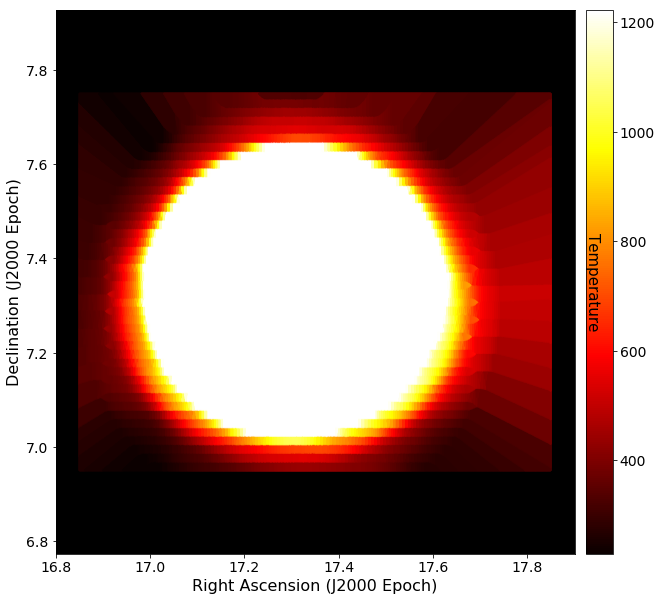

In [12]:
title = date + ' Interpolated LCP Horizontal Raster Scan Data (Measured at 12.18 GHz)'
h = 17.3
k = 7.3
r = 0.45
inter_LCP_H = interpolate(RA_LCP_H, Dec_LCP_H, values_LCP_H, h, k, r, title)

## Interpolate LCP Vertical

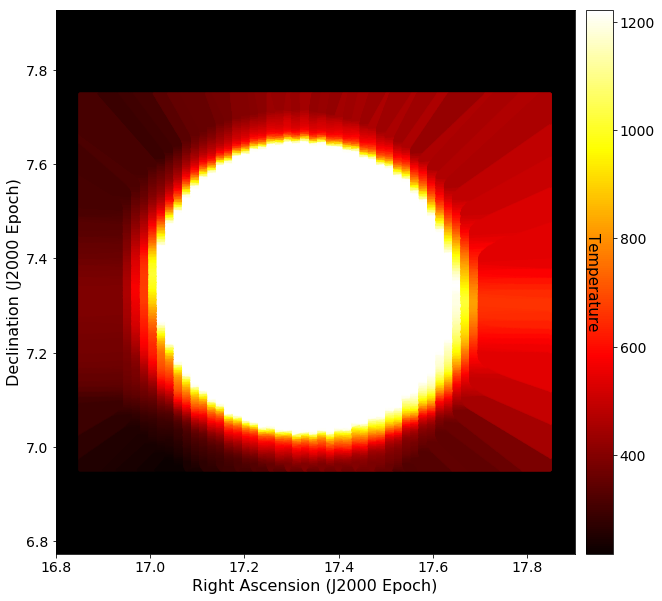

In [13]:
title = date + ' Interpolated LCP Vertical Raster Scan Data (Measured at 12.18 GHz)'
h = 17.3
k = 7.3
r = 0.42
inter_LCP_V = interpolate(RA_LCP_V, Dec_LCP_V, values_LCP_V, h, k, r, title)

## Interpolate RCP Horizontal

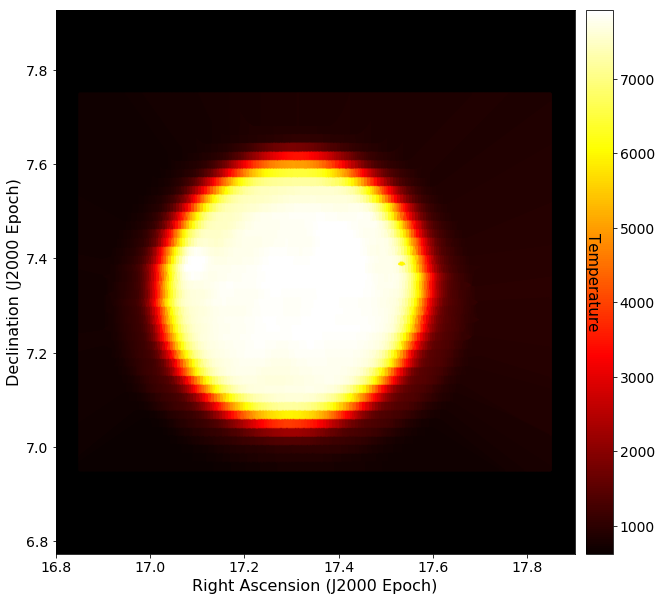

In [14]:
title = date + ' Interpolated RCP Horizontal Raster Scan Data (Measured at 12.18 GHz)'
h = 17.3
k = 7.3
r = 0.40
inter_RCP_H = interpolate(RA_RCP_H, Dec_RCP_H, values_RCP_H, h, k, r, title)

## Interpolate RCP Vertical

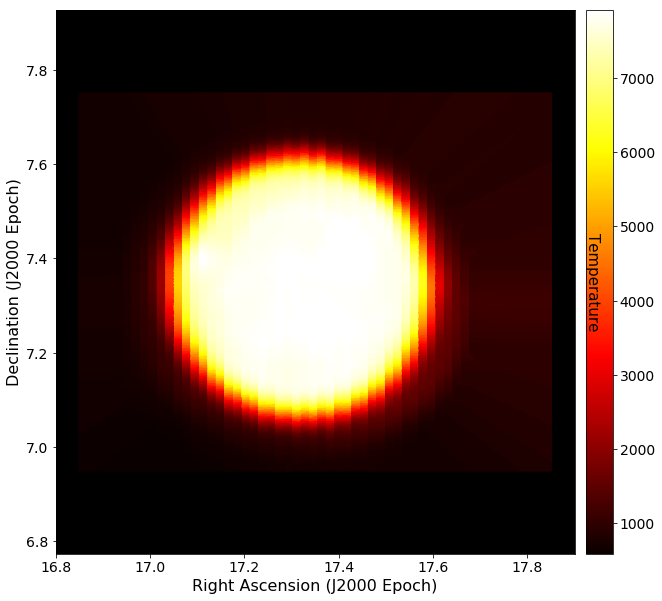

In [15]:
title = date + ' Interpolated RCP Vertical Raster Scan Data (Measured at 12.18 GHz)'
h = 17.3
k = 7.3
r = 0.40
inter_RCP_V = interpolate(RA_RCP_V, Dec_RCP_V, values_RCP_V, h, k, r, title)

## Take Averages

In [16]:
temp_H = (inter_LCP_H + inter_RCP_H)/2.0
temp_V = (inter_LCP_V + inter_RCP_V)/2.0
temp = (temp_H + temp_V)/2.0

In [17]:
temp = (inter_RCP_H + inter_RCP_V)/2.0

## Plot Final Figure

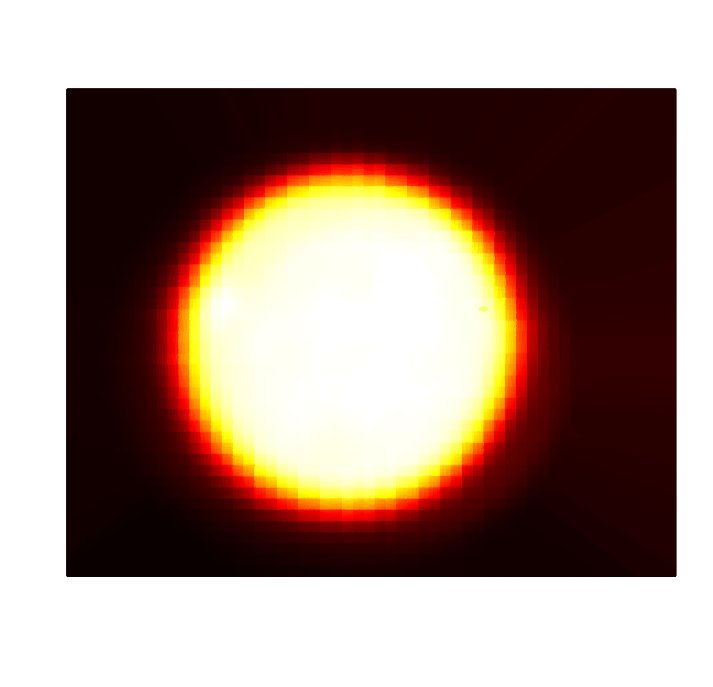

In [18]:
# Create Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 12))
ax.set_facecolor('white')

plt.scatter(grid_x, grid_y, c = temp, cmap = cm.hot, s = 1)
    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.axis('equal')
plt.axis('off')
plt.show()